# Object Detection in Video Frames with YOLOv8m

This example demonstrates the object detection model inference on the embedded Neural Processing Unit (NPU) in your AMD Ryzen AI enabled PC with either single image or the live webcam. 

In [1]:
# Before starting, be sure you've installed the requirements listed in the requirements.txt file:
!python -m pip install -r requirements.txt

### Get Model from Ryzen AI model zoo
The yolov8m model from [Ryzen AI model zoo](https://huggingface.co/amd) will be applied in this example.

In [2]:
# Notebook dependencies
from huggingface_hub import hf_hub_download
from yolov8_utils import get_directories

current_dir = get_directories()

# Download Yolov8 model from Ryzen AI model zoo. Registration is required before download.
hf_hub_download(repo_id="amd/yolov8m", filename="yolov8m.onnx", local_dir=str(current_dir))


c:\Users\tgmeinde\AppData\Local\miniconda3\envs\ryzen-ai-1.3.0\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\\Users\\tgmeinde\\GHE\\RyzenAI-SW\\tutorial\\yolov8\\yolov8_python\\yolov8m.onnx'

### Define pre and post processing functions



In [3]:
import torch
import torch.nn as nn
import onnxruntime
import numpy as np


def preprocess(img):
    img = torch.from_numpy(img)
    img = img.float()  # uint8 to fp16/32
    img /= 255  # 0 - 255 to 0.0 - 1.0
    return img


class DFL(nn.Module):
    # Integral module of Distribution Focal Loss (DFL) proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    def __init__(self, c1=16):
        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(
            b, 4, a
        )


def dist2bbox(distance, anchor_points, xywh=True, dim=-1):
    """Transform distance(ltrb) to box(xywh or xyxy)."""
    lt, rb = torch.split(distance, 2, dim)
    x1y1 = anchor_points - lt
    x2y2 = anchor_points + rb
    if xywh:
        c_xy = (x1y1 + x2y2) / 2
        wh = x2y2 - x1y1
        return torch.cat((c_xy, wh), dim)  # xywh bbox
    return torch.cat((x1y1, x2y2), dim)  # xyxy bbox


def post_process(x):
    dfl = DFL(16)
    anchors = torch.tensor(
        np.load(
            "./anchors.npy",
            allow_pickle=True,
        )
    )
    strides = torch.tensor(
        np.load(
            "./strides.npy",
            allow_pickle=True,
        )
    )
    box, cls = torch.cat([xi.view(x[0].shape[0], 144, -1) for xi in x], 2).split(
        (16 * 4, 80), 1
    )
    dbox = dist2bbox(dfl(box), anchors.unsqueeze(0), xywh=True, dim=1) * strides
    y = torch.cat((dbox, cls.sigmoid()), 1)
    return y, x



### Prepare the Dataset
This will download 555 MB so may take a while depending on the download bandwidth.

In [4]:
!git clone --progress https://github.com/JoyKarmoker/YOLOv8-Object-Detection-on-Video-with-OpenCV 

fatal: destination path 'YOLOv8-Object-Detection-on-Video-with-OpenCV' already exists and is not an empty directory.


### Define Video to be processed

In [5]:
from yolov8_utils import *

imgsz = [640, 640]
video_name =  "motorbikes.mp4"
video_path = f"./YOLOv8-Object-Detection-on-Video-with-OpenCV/Videos/{video_name}"

# Load image
dataset = LoadImages(
    video_path, imgsz=imgsz, stride=32, auto=False, transforms=None, vid_stride=1
)

num_frames = 0
for frame in dataset:
    num_frames += 1

print(f"Video {video_name} has {num_frames} frames")


Video motorbikes.mp4 has 686 frames


### Detect Target Hardware and set Environment

read the PCI device ids, detect the type of the target hardware and set the environment accordingly.

In [6]:
import subprocess
command = r'pnputil /enum-devices /bus PCI /deviceids '
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
# Check for supported Hardware IDs
apu_type = ''
if 'PCI\\VEN_1022&DEV_1502&REV_00' in stdout.decode(): apu_type = 'PHX/HPT'
if 'PCI\\VEN_1022&DEV_17F0&REV_00' in stdout.decode(): apu_type = 'STX'
if 'PCI\\VEN_1022&DEV_17F0&REV_10' in stdout.decode(): apu_type = 'STX'
if 'PCI\\VEN_1022&DEV_17F0&REV_11' in stdout.decode(): apu_type = 'STX'

print(f"APU Type: {apu_type}")

# For Benchmarking
#overlay = 'AMD_AIE2P_4x4_Overlay'
overlay = 'AMD_AIE2P_Nx4_Overlay'

install_dir = os.environ['RYZEN_AI_INSTALLATION_PATH']
match apu_type:
    case 'PHX/HPT':
        print("Setting environment for PHX/HPT")
        #aie_array = '4x4'
        aie_array = 'Nx4'
        os.environ['XLNX_VART_FIRMWARE']= os.path.join(install_dir, 'voe-4.0-win_amd64', 'xclbins', 'phoenix', f'{aie_array}.xclbin')
        os.environ['NUM_OF_DPU_RUNNERS']='1'
        #os.environ['XLNX_TARGET_NAME']= f'AMD_AIE2_{aie_array}_Overlay'
        os.environ['XLNX_TARGET_NAME']= f'AMD_AIE2_{aie_array}_Overlay'
    case 'STX':
        print("Setting environment for STX")
        aie_array = '4x4'
        #aie_array = 'Nx4'
        os.environ['XLNX_VART_FIRMWARE']= os.path.join(install_dir, 'voe-4.0-win_amd64', 'xclbins', 'strix', f'AMD_AIE2P_{aie_array}_Overlay.xclbin')
        os.environ['NUM_OF_DPU_RUNNERS']='1'
        os.environ['XLNX_TARGET_NAME']= f'AMD_AIE2P_{aie_array}_Overlay'
        #os.environ['XLNX_TARGET_NAME']= f'AMD_AIE2P_{aie_array}_Overlay'
    case _:
        print("Unrecognized APU type. Exiting.")
        exit()
print('XLNX_VART_FIRMWARE=', os.environ['XLNX_VART_FIRMWARE'])
print('NUM_OF_DPU_RUNNERS=', os.environ['NUM_OF_DPU_RUNNERS'])
print('XLNX_TARGET_NAME=', os.environ['XLNX_TARGET_NAME'])


APU Type: STX
Setting environment for STX
XLNX_VART_FIRMWARE= C:\Program Files\RyzenAI\1.3.0_vaiml\voe-4.0-win_amd64\xclbins\strix\AMD_AIE2P_4x4_Overlay.xclbin
NUM_OF_DPU_RUNNERS= 1
XLNX_TARGET_NAME= AMD_AIE2P_4x4_Overlay


### Run Inference on Video Frames

We will leverage the onnxruntime to do run inference on a sequence of video frames. The exeuction provider (EP) can be chosen to run inference on CPU, iGPU and NPU.
The bounding boxes of the detected objects will then be drawn on the image and visualised as output video.

### Select the execution provider and create the inference session

In [7]:

# Specify the path to the quantized ONNX Model
onnx_model_path = "yolov8m.onnx"

# Select the ONNX Execution Provider
EP = "VitisAIExecutionProvider" # NPU
#EP = "CPUExecutionProvider"    # CPU
#EP = "DmlExecutionProvider"    # iGPU

# Point to the config file path used for the VitisAI Execution Provider
config_file_path = "./vaip_config.json"

AIA = True # Set to True to enable AI Analyzer

provider_options = [{
              'config_file': config_file_path,
              'ai_analyzer_visualization': AIA,
              'ai_analyzer_profiling': AIA,
          }]

npu_session = onnxruntime.InferenceSession(
    onnx_model_path,
    providers = [EP],
    provider_options = provider_options
)
print(f"onnxruntime.InferenceSession created with EP {EP} and AI Analyzer {AIA}")

onnxruntime.InferenceSession created with EP VitisAIExecutionProvider and AI Analyzer True


### Run object detection inference on the video

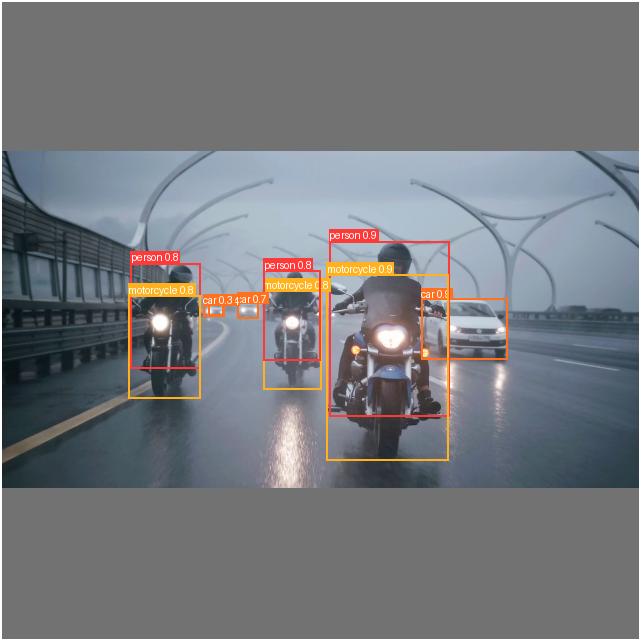


Average inference time with EP VitisAIExecutionProvider: 206.06 ms
Video processing time: 64.91 s


In [8]:
from IPython.display import clear_output
import os

# Load labels of coco dataaset
with open('coco.names', 'r') as f:
        names = f.read()

names = names.splitlines()

inference_output_dir = "inference_output"

if not os.path.exists(inference_output_dir):
    os.mkdir(inference_output_dir)

dataset = LoadImages(
    video_path, imgsz=imgsz, stride=32, auto=False, transforms=None, vid_stride=3
)
max_det = 300

print(f"Running Inference on frames in video {video_name} with model {onnx_model_path} on ONNX EP {EP}")
num_frames = 0
video_start_time = time.time()
total_inference_time = 0
for batch in dataset:
    path, im, im0s, vid_cap, s = batch

    im = preprocess(im)
    if len(im.shape) == 3:
        im = im[None]

    input_image = im.permute(0, 2, 3, 1).cpu().numpy()
    start = time.time()
    outputs = npu_session.run(None, {npu_session.get_inputs()[0].name: input_image})
    end = time.time()

    inference_time = np.round((end - start) * 1000, 2)
    total_inference_time += inference_time

    # Postprocessing
    outputs = [torch.tensor(item).permute(0, 3, 1, 2) for item in outputs]
    preds = post_process(outputs)
    preds = non_max_suppression(
        preds, 0.25, 0.7, agnostic=False, max_det=max_det, classes=None
    )
    
    output_path = f"{inference_output_dir}/{video_name}_frame_{num_frames}.jpg"
    clear_output(wait=True) # clear the output cell
    plot_images(
        im,
        *output_to_target(preds, max_det=max_det),
        fname=output_path,
        names=names,
    )
    num_frames += 1

    num_det_objects = preds[0].size(0)
    #print(f"Detected {num_det_objects} Objects. Inference time: {inference_time} ms")

video_time = np.round((time.time() - video_start_time), 2)
avg_inference_time = total_inference_time / num_frames
print(f"\nAverage inference time with EP {EP}: {avg_inference_time:.2f} ms")
print(f"Video processing time: {video_time} s")

### Optional: Analyse model execution on NPU
If AIA was set to true, data was generated for AI Analyzer and it will be launched in a webbrowser by the following cell. Documentation for the tool can be found here: https://ryzenai.docs.amd.com/en/latest/ai_analyzer.html.

In [ ]:
if AIA:
    !aianalyzer ./ -p 8001